In [2]:
import os
import numpy as np
import h5py
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import (Linear, ReLU, Conv1d, Flatten, Conv2d, Sequential,MaxPool1d, MaxPool2d, Dropout, CrossEntropyLoss)
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from skimage.io import imread, imshow
from skimage.transform import resize

import sklearn
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold

from utils import make_iter,model_fit,call_model

In [3]:
#################################################
# Grab Data
#################################################
def get_LC(filepath):

    fin = h5py.File(filepath,'r')
    localview = fin['LocalView'].get("Aperture_%.3d" % fin['bestap'][0]).value
    fin.close()
    return localview

def get_data(TICS_folderpath,label_filepath,verbose=1):

    X = np.zeros((0,61),dtype='float')
    y = np.zeros((0,),dtype='int')
    ids = np.empty((0,),dtype='str')

    known_planets = np.genfromtxt(label_filepath,dtype='str')

    sectors = ["sector-{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

    for sector in sectors:
        # get the ids
        sectorids = os.listdir(os.path.join(TICS_folderpath,sector,"preprocessed"))
        if verbose: print("\n%s" % sector)

        for i,file in enumerate(sectorids):

            if verbose: print("--{:5d} / {:5d}\r".format(i,len(sectorids)),end='')
            filepath = os.path.join(TICS_drive,sector,"preprocessed",file)

            # get the lightcurve
            try:
                nX = get_LC(filepath)
            except:
                if verbose: print("bad file: ", filepath)
            # print(nX.shape, X.shape)
            X = np.vstack([X,nX])

            # get the label
            if file in known_planets:
                y = np.append(y,[1],axis=0)
            else:
                y = np.append(y,[0],axis=0)


        # get the id
        ids = np.append(ids,sectorids,axis=0)

    return X,y,ids

def generate_data(TICS_drive,generate_input,overwrite,verbose=0):

    if generate_input:
        
        # File containing names of known planets
        planets_file = os.path.join(TICS_drive,"planets.txt")

        # Generate input data
        Xfile = os.path.join(TICS_drive,"Xdata_cnn.npy")
        yfile = os.path.join(TICS_drive,"ydata_cnn.npy")
        idfile = os.path.join(TICS_drive,"ids_cnn.npy")

        if (os.path.exists(Xfile)==False) or \
            (os.path.exists(yfile)==False) or \
            (os.path.exists(idfile)==False) or overwrite:
            if verbose: print("generating input data")
            X,y,ids = get_data(TICS_drive, planets_file, verbose=verbose)
            np.save(Xfile,X)
            np.save(yfile,y)
            np.save(idfile,ids) 
        else:
            if verbose: print("not generating new data: overwrite off...")

    if verbose: print("loading existing input data...")
    X = np.load(os.path.join(TICS_drive,"Xdata_cnn.npy"))
    y = np.load(os.path.join(TICS_drive,"ydata_cnn.npy"))
    ids = np.load(os.path.join(TICS_drive,"ids_cnn.npy"))
    if verbose: print("X.shape, y.shape, ids.shape = ", X.shape, y.shape, ids.shape)

    return X,y,ids

def split_data(X,y,ids,n_fold):

    skf = StratifiedKFold(n_splits=5,shuffle=True)

    # only use first fold for now
    train_i, test_i = next(skf.split(X, y))

    return (X[train_i,:],y[train_i],ids[train_i]), (X[test_i,:],y[test_i],ids[test_i])

In [151]:
def make_deterministic():
    torch.manual_seed(10)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(10)

def weight_reset(l):
    if isinstance(l, Conv2d) or isinstance(l, Linear):
        l.reset_parameters()

def run_pytorch(train_iter, val_iter, test_iter, layers, epochs,weights,verbose=True):

    # Model specification
    model = Sequential(*layers)

    # Define the optimization
    optimizer = Adam(model.parameters())
    criterion = CrossEntropyLoss(weight=weights)

    
    # Fit the model
    train_m, vali_m = model_fit(model, train_iter, epochs=epochs, 
                                optimizer=optimizer, criterion=criterion,
                                validation_iter=val_iter,
                                verbose=verbose,history=None)
    if verbose: print()
    
    (train_loss, train_acc) = train_m
    (vali_loss, val_acc) = vali_m
    
    # Evaluate the model on test data, if any
    if test_iter is not None:
        test_loss, test_acc = model_evaluate(model, test_iter, criterion)
        print ("\nLoss on test set:"  + str(test_loss) + " Accuracy on test set: " + str(test_acc))
    else:
        test_acc = None
    return model, val_acc, test_acc

def run_pytorch_fc(train, test, layers, epochs, verbose=True, trials=1, deterministic=True):
    '''
    train, test = input data
    layers = list of PyTorch layers, e.g. [Linear(in_features=784, out_features=10)]
    epochs = number of epochs to run the model for each training trial
    trials = number of evaluation trials, resetting weights before each trial
    '''
    if deterministic:
        make_deterministic()
    (X_train, y1), (X_val, y2) = train, test

    # weights
    weights = torch.tensor(sklearn.utils.class_weight.compute_class_weight('balanced',[0,1],y1),dtype=torch.float64)

    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        for l in layers:
            weight_reset(l)
        # Make Dataset Iterables
        train_iter, val_iter = make_iter(X_train, y1, batch_size=32), make_iter(X_val, y2, batch_size=32)
        # Run the model
        model, vacc, tacc = \
            run_pytorch(train_iter, val_iter, None, layers, epochs, \
                        torch.tensor([.1,200],dtype=torch.float32), verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print("\nAvg. validation accuracy:" + str(val_acc / trials))
    if test_acc:
        print("\nAvg. test accuracy:" + str(test_acc / trials))

    # WARNING: must cast input to FloatTensor not Double Tensor
    predict = model(torch.FloatTensor(X_val)).data.numpy()

    return sklearn.metrics.precision_recall_curve(y2, np.amax(predict,axis=1) , pos_label=1)

def run_pytorch_cnn(train, test, layers, epochs, verbose=True, trials=1, deterministic=True):
    
    if deterministic: make_deterministic()
    
    # Load the dataset
    (X_train, y1), (X_val, y2) = train, test
    # Add a final dimension indicating the number of channels (only 1 here)
    
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], 1, m))
    X_val = X_val.reshape((X_val.shape[0], 1, m))

    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        for l in layers:
            weight_reset(l)
        # Make Dataset Iterables
        train_iter, val_iter = make_iter(X_train, y1, batch_size=4), make_iter(X_val, y2, batch_size=4)
        # Run the model
        model, vacc, tacc = \
            run_pytorch(train_iter, val_iter, None, layers, epochs, \
                        torch.tensor([.5,50],dtype=torch.float32), verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print("\nAvg. validation accuracy:" + str(val_acc / trials))
    if test_acc:
        print("\nAvg. test accuracy:" + str(test_acc / trials))

    predict = model(torch.FloatTensor(X_val)).data.numpy()

    return sklearn.metrics.precision_recall_curve(y2, np.amax(predict,axis=1) , pos_label=1)


In [202]:
# runtime options
verbose = 1
generate_input = True
overwrite = False  

# TICS folder which has binned lightcurves
TICS_drive   = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/"

# generate data and split
X,y,ids = generate_data(TICS_drive,generate_input,overwrite,verbose=verbose)

# filter out bad data
peakmean = np.amin(X,axis=1)
X,y,ids = X[peakmean != 0], y[peakmean !=0], ids[peakmean!=0]

# test normalize
# X = (X - np.mean(X,axis=0)) / np.std(X,axis=0)
# X = (X - np.mean(X,axis=0,keepdims=True)) / np.std(X,axis=1,keepdims=True)
X /= np.fabs(np.amin(X,axis=1,keepdims=True))

(X_train,y_train, ids_train), (X_valid, y_valid, ids_valid) = split_data(X,y,ids,5)
train = (X_train,y_train)
test  = (X_valid, y_valid)

# layers = [ \
#           nn.Conv1d(in_channels=1, out_channels=1,kernel_size=3), \
#           nn.ReLU(), \
#           nn.Dropout(p=0.5), \
#           nn.MaxPool1d(kernel_size=2),
#           nn.Flatten(),
#           nn.Linear(in_features=29, out_features=20), \
#           nn.Linear(in_features=20,out_features=2)]


# ftest = run_pytorch_cnn(train, test , layers, 1, verbose=verbose,trials=1)

# layers = [ \
#     nn.Linear(in_features=61, out_features=256), \
#     nn.ReLU(), \
#     nn.Linear(in_features=256,out_features=256), \
#     nn.ReLU(), \
#     nn.Linear(in_features=256,out_features=256), \
#     nn.ReLU(), \
#     nn.Linear(in_features=256,out_features=256), \
#     nn.ReLU(), \
#     nn.Linear(in_features=256,out_features=2)]

# test = run_pytorch_fc(train, test , layers, 5, verbose=verbose,trials=1)

not generating new data: overwrite off...
loading existing input data...
X.shape, y.shape, ids.shape =  (171117, 61) (171117,) (171117,)


In [203]:
layers = [ \
          nn.Conv1d(in_channels=1, out_channels=1,kernel_size=3), \
          nn.ReLU(), \
          nn.MaxPool1d(kernel_size=2),
          nn.Flatten(),
          nn.Linear(in_features=29, out_features=2)]


ftest = run_pytorch_cnn(train, test , layers, 1, verbose=verbose,trials=1)

epoch: 0 | TRAIN: loss 0.03477 acc 0.98946 | VALI: loss 0.03842 acc 0.99082


Avg. validation accuracy:0.9908160280783855


In [183]:
layers2 = [ \
          nn.Conv1d(in_channels=1, out_channels=2,kernel_size=3), \
          nn.ReLU(), \
          nn.MaxPool1d(kernel_size=2),
          nn.Conv1d(in_channels=2, out_channels=4,kernel_size=3), \
          nn.ReLU(), \
          nn.MaxPool1d(kernel_size=2),
          nn.Flatten(),
          nn.Linear(in_features=13 * 4, out_features=2)]


ftest2 = run_pytorch_cnn(train, test , layers2, 1, verbose=verbose,trials=1)

epoch: 0 | TRAIN: loss 0.03421 acc 0.99078 | VALI: loss 0.03449 acc 0.99082


Avg. validation accuracy:0.9908160280783855


In [ ]:
# layers3 = [ \
          nn.Conv1d(in_channels=1, out_channels=16,kernel_size=3), \
          nn.ReLU(), \
          nn.Dropout(p=0.5), \
          nn.MaxPool1d(kernel_size=2),
          nn.Conv1d(in_channels=16, out_channels=32,kernel_size=3), \
          nn.ReLU(), \
          nn.Dropout(p=0.5), \
          nn.MaxPool1d(kernel_size=2),
          nn.Flatten(),
          nn.Linear(in_features=32 * 13, out_features=20), \
          nn.Linear(in_features=20,out_features=2)]

ftest3 = run_pytorch_cnn(train, test , layers3, 1, verbose=verbose,trials=1)

(0, 0.02)

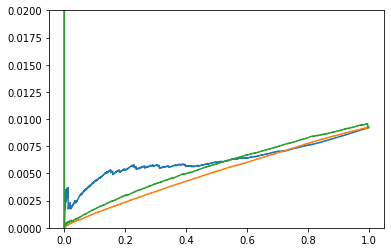

In [205]:
plt.plot(ftest[1],ftest[0])
plt.plot(ftest2[1],ftest2[0])
plt.plot(ftest3[1],ftest3[0])

plt.ylim([0,.02])

In [147]:
np.sum(y == 1) / np.sum(y == 0)

0.009292934063857925

not generating new data: overwrite off...
loading existing input data...
X.shape, y.shape, ids.shape =  (171117, 61) (171117,) (171117,)


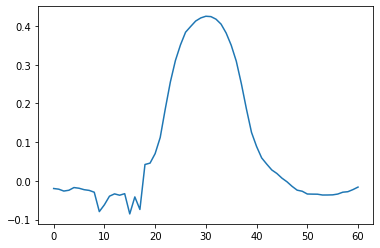

In [130]:
# generate data and split
X,y,ids = generate_data(TICS_drive,generate_input,overwrite,verbose=verbose)

# filter out bad data
peakmean = np.amin(X,axis=1)
X,y,ids = X[peakmean != 0], y[peakmean !=0], ids[peakmean!=0]

i = 10
# plt.plot(X[i])
Xnew = (X - np.mean(X,axis=0)) / np.std(X,axis=0)
plt.plot(Xnew[y==0][i])

In [206]:
# generate data and split
X,y,ids = generate_data(TICS_drive,generate_input,overwrite,verbose=verbose)

# filter out bad data
peakmean = np.amin(X,axis=1)
ids[peakmean == 0]

not generating new data: overwrite off...
loading existing input data...
X.shape, y.shape, ids.shape =  (171117, 61) (171117,) (171117,)


array(['341547271.h5', '135339029.h5', '140105580.h5', '140113649.h5',
       '144935125.h5', '145212351.h5', '145805829.h5', '147830687.h5',
       '149031119.h5', '149632513.h5', '149724039.h5', '149808284.h5',
       '150238535.h5', '15169762.h5', '152041647.h5', '154109038.h5',
       '154116157.h5', '154445467.h5', '155757469.h5', '161388833.h5',
       '161483764.h5', '161777859.h5', '161892275.h5', '162751973.h5',
       '162852012.h5', '163440492.h5', '163936563.h5', '164029957.h5',
       '164713705.h5', '170986665.h5', '172278394.h5', '172616002.h5',
       '173261367.h5', '174859881.h5', '176456302.h5', '179609869.h5',
       '179622900.h5', '189826604.h5', '189879077.h5', '214977063.h5',
       '214978922.h5', '215006672.h5', '215260592.h5', '215430358.h5',
       '215599829.h5', '215640930.h5', '215695485.h5', '215849183.h5',
       '215986986.h5', '216006236.h5', '221554586.h5', '221873499.h5',
       '221984125.h5', '222064155.h5', '222835212.h5', '222843759.h5',
       

In [103]:
np.sum(np.logical_and((peakmean==0), (y == 1)))

0